## Titanic: Machine Learning from Disaster

---

### Overview

This is an intro ML competition from Kaggle, described [here](https://www.kaggle.com/c/titanic).

Training data is [here](https://www.kaggle.com/c/titanic/download/train.csv) and validation data is [here](https://www.kaggle.com/c/titanic/download/test.csv).

#### Data Dictionary

Variable | Definition | Key
--- | --- | ---
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex	
Age	| Age in years	
sibsp |	# of siblings / spouses aboard the Titanic	
parch | # of parents / children aboard the Titanic	
ticket | Ticket number	
fare | Passenger fare	
cabin | Cabin number	
embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton


#### Variable Notes

**pclass**: A proxy for socio-economic status (SES)
**1st** = Upper
**2nd** = Middle
**3rd** = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...

*Sibling* = brother, sister, stepbrother, stepsister
*Spouse* = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...

*Parent* = mother, father
*Child* = daughter, son, stepdaughter, stepson


### Solution

In [1]:
# start off by ensuring the test and training data have been downloaded.

import os
import tarfile
from six.moves import urllib
import os.path

TRAIN_FILE = "train.csv"
TEST_FILE = "test.csv"
LOCAL_DATA_PATH = './tmp/'

input_files = [TRAIN_FILE, TEST_FILE]
for file in input_files:
    if not os.path.isfile(LOCAL_DATA_PATH + file):
        raise ValueError('Missing file: ' + file)

In [2]:
# display the raw input training data
import pandas as pd

raw_train_df = pd.read_csv(LOCAL_DATA_PATH + TRAIN_FILE)
raw_test_df = pd.read_csv(LOCAL_DATA_PATH + TEST_FILE)
raw_train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
# stats of the numeric columns
raw_train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# 891 rows of 12 columns
raw_train_df.shape

(891, 12)

In [6]:
# we can convert this to a boolean
raw_train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [7]:
# this should be a categorical. there's no real value in the #
raw_train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [8]:
# we might be able to extract some information based on title (mr., Mrs. etc.)
raw_train_df.head(5)['Name']

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [9]:
# we can convert this to a categorical
raw_train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
# not sure there's any useful info in the ticket #s
raw_train_df['Ticket'].value_counts().head(5)

347082      7
1601        7
CA. 2343    7
CA 2144     6
3101295     6
Name: Ticket, dtype: int64

In [11]:
# we can identify those with multiple cabins (true/false)
# we can also extract deck and room # features
# in cases of multiple cabins, just pick the 'best' deck, aka. closest to A.
raw_train_df['Cabin'].value_counts().head(10)

G6                 4
B96 B98            4
C23 C25 C27        4
C22 C26            3
D                  3
F33                3
E101               3
F2                 3
B49                2
B57 B59 B63 B66    2
Name: Cabin, dtype: int64

In [12]:
# we can convert this to a categorical
raw_train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [13]:
# create a method to transform both the training set and the validation set
# will clean data and perform feature engineering here

# find best cabin if multiple cabins, and extract deck/room numbers
def get_cabin_details(raw_cabin):
    all_cabins = raw_cabin.split(' ')
    best_cabin = sorted(all_cabins)[0]
    
    deck = list(filter(lambda c: not c.isdigit(), best_cabin))[0]
    room_number = ''.join(list(filter(lambda c: c.isdigit(), best_cabin)))
    
    multiple_cabins = len(all_cabins) > 1
    
    return (deck, room_number, multiple_cabins)

def clean_df(raw_df):
    raw_df = raw_df.set_index('PassengerId')
    df = pd.DataFrame(index=raw_df.index)

    # convert survived (ground truth) to boolean column (doesn't exist in test set)
    if 'Survived' in raw_df.columns:
        df['survived'] = raw_df['Survived'].astype('bool')  * 1
    
    # map passenger class to categories
    preference_map = {1: 'upper', 2: 'middle', 3: 'lower'}
    df['p_class'] = raw_df['Pclass'].map(preference_map).astype('category')
    
    # map sex to categories
    df['sex'] = raw_df['Sex'].astype('category')
    
    # copy age directly
    df['age'] = raw_df['Age']
    
    # copy sibling/spouse count directly
    df['sibling_spouse_count'] = raw_df['SibSp'].astype(float)
    
    # copy parent/child count directly
    df['parent_child_count'] = raw_df['Parch'].astype(float)
    
    # copy fare directly
    df['fare'] = raw_df['Fare']
    
    cabin_details = raw_df['Cabin'].dropna().apply(get_cabin_details)
    df['deck'] = cabin_details.apply(lambda x: x[0])
    df['room_number'] = pd.to_numeric(cabin_details.apply(lambda x: x[1]))
    df['multiple_cabins'] = cabin_details.apply(lambda x: x[2])
    
    # map passenger class to categories
    preference_map = {'C': 'cherbourg', 'Q': 'queenstown', 'S': 'southampton'}
    df['embarked_from'] = raw_df['Embarked'].map(preference_map).astype('category')
    
    df = pd.get_dummies(df, columns= ['embarked_from', 'deck', 'sex', 'multiple_cabins', 'p_class'])

    return df

In [14]:
cleaned_train_df = clean_df(raw_train_df)
cleaned_test_df = clean_df(raw_test_df)

In [15]:
missing_columns = list(set(cleaned_train_df.columns.values) - set(cleaned_test_df.columns.values))
for column in missing_columns:
    cleaned_test_df[column] = None

In [16]:
cleaned_train_df = cleaned_train_df.reindex_axis(sorted(cleaned_train_df.columns), axis=1)
cleaned_test_df = cleaned_test_df.reindex_axis(sorted(cleaned_test_df.columns), axis=1)

In [17]:
# assert the same dimensions

if not cleaned_test_df.shape[1] == cleaned_train_df.shape[1]:
    raise 'training and test columns dont match'

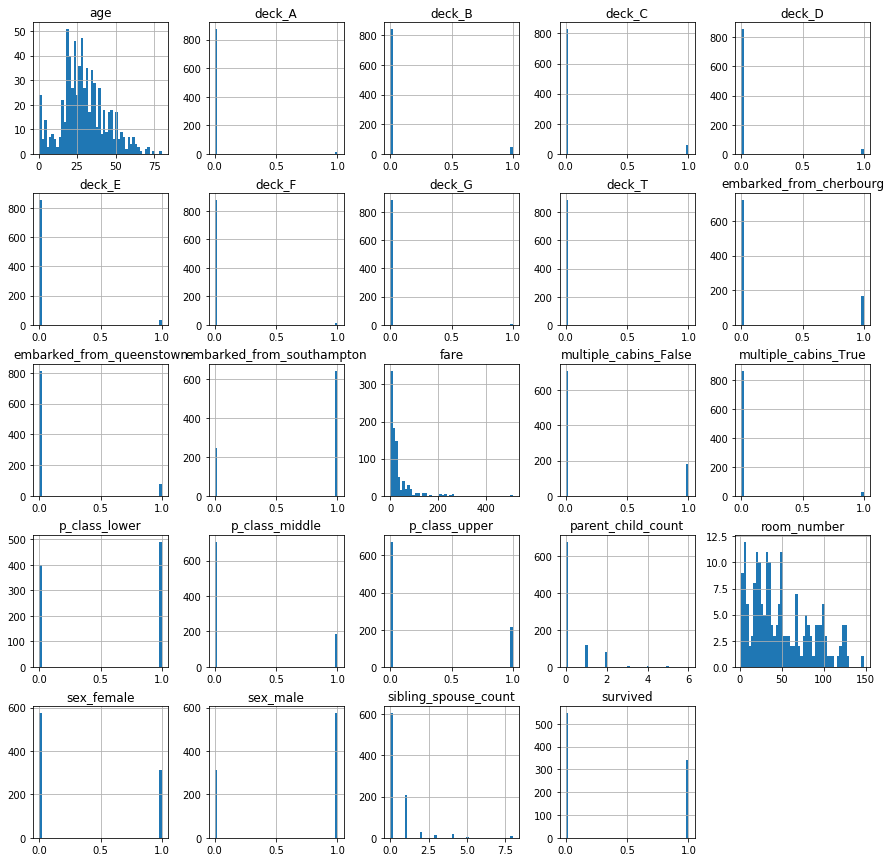

In [18]:
%matplotlib inline 
import matplotlib.pyplot as plt
cleaned_train_df.hist(bins=50, figsize=(15,15))
plt.show()

In [19]:
corr_matrix = cleaned_train_df.corr()
corr_matrix

,age,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,embarked_from_cherbourg,...,multiple_cabins_True,p_class_lower,p_class_middle,p_class_upper,parent_child_count,room_number,sex_female,sex_male,sibling_spouse_count,survived
age,1.000000,0.136309,0.093914,0.122041,0.136975,0.121440,-0.083970,-0.077296,0.039474,0.036261,...,-0.039977,-0.312271,0.006954,0.348941,-0.189119,0.072952,-0.093254,0.093254,-0.308247,-0.077221
deck_A,0.136309,1.000000,-0.030880,-0.034846,-0.025663,-0.025663,-0.015289,-0.008787,-0.004386,0.093040,...,-0.021772,-0.144979,-0.066756,0.231323,-0.040325,-0.242663,-0.078271,0.078271,-0.046266,0.022287
deck_B,0.093914,-0.030880,1.000000,-0.062841,-0.046280,-0.046280,-0.027572,-0.015847,-0.007910,0.168642,...,0.301880,-0.261450,-0.120386,0.417160,0.056498,0.027752,0.109689,-0.109689,-0.034538,0.175095
deck_C,0.122041,-0.034846,-0.062841,1.000000,-0.052225,-0.052225,-0.031114,-0.017883,-0.008926,0.113952,...,0.178725,-0.295036,-0.135851,0.470749,0.030736,0.466637,0.058649,-0.058649,0.029251,0.114652
deck_D,0.136975,-0.025663,-0.046280,-0.052225,1.000000,-0.038462,-0.022914,-0.013170,-0.006574,0.102977,...,0.004079,-0.217282,-0.041325,0.291218,-0.019125,-0.253958,0.079248,-0.079248,-0.017575,0.150716
deck_E,0.121440,-0.025663,-0.046280,-0.052225,-0.038462,1.000000,-0.022914,-0.013170,-0.006574,-0.003376,...,0.004079,-0.169489,-0.041325,0.235748,-0.011748,-0.004417,0.054368,-0.054368,-0.033751,0.150716
deck_F,-0.083970,-0.015289,-0.027572,-0.031114,-0.022914,-0.022914,1.000000,-0.007846,-0.003917,-0.056322,...,0.160986,-0.051148,0.132819,-0.066095,0.017173,-0.206040,-0.004667,0.004667,-0.002439,0.047930
deck_G,-0.077296,-0.008787,-0.015847,-0.017883,-0.013170,-0.013170,-0.007846,1.000000,-0.002251,-0.032371,...,-0.011173,0.060612,-0.034258,-0.037988,0.072388,-0.179289,0.091031,-0.091031,-0.001402,0.016040
deck_T,0.039474,-0.004386,-0.007910,-0.008926,-0.006574,-0.006574,-0.003917,-0.002251,1.000000,-0.016158,...,-0.005577,-0.037138,-0.017100,0.059256,-0.015878,NaN,-0.024728,0.024728,-0.015907,-0.026456
embarked_from_cherbourg,0.036261,0.093040,0.168642,0.113952,0.102977,-0.003376,-0.056322,-0.032371,-0.016158,1.000000,...,0.079306,-0.153329,-0.125416,0.296423,-0.011069,0.017734,0.082853,-0.082853,-0.059528,0.168240


In [20]:
corr_matrix['survived'].sort_values(ascending=False)

survived                     1.000000
sex_female                   0.543351
multiple_cabins_False        0.304115
p_class_upper                0.285904
fare                         0.257307
deck_B                       0.175095
embarked_from_cherbourg      0.168240
deck_D                       0.150716
deck_E                       0.150716
deck_C                       0.114652
p_class_middle               0.093349
parent_child_count           0.081629
multiple_cabins_True         0.068251
deck_F                       0.047930
deck_A                       0.022287
deck_G                       0.016040
embarked_from_queenstown     0.003650
deck_T                      -0.026456
sibling_spouse_count        -0.035322
room_number                 -0.052910
age                         -0.077221
embarked_from_southampton   -0.155660
p_class_lower               -0.322308
sex_male                    -0.543351
Name: survived, dtype: float64

## Transformation

Let's build a pipeline to do imputing of missing data etc.

In [21]:
train_x = cleaned_train_df.drop("survived", axis=1).reset_index().drop('PassengerId', axis=1)
train_y = cleaned_train_df["survived"].copy().reset_index().drop('PassengerId', axis=1)
test_x = cleaned_test_df.drop("survived", axis=1).reset_index().drop('PassengerId', axis=1)

In [22]:
train_x.head()

,age,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,embarked_from_cherbourg,...,multiple_cabins_False,multiple_cabins_True,p_class_lower,p_class_middle,p_class_upper,parent_child_count,room_number,sex_female,sex_male,sibling_spouse_count
0,22.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0.0,NaN,0,1,1.0
1,38.0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,1,0.0,85.0,1,0,1.0
2,26.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0.0,NaN,1,0,0.0
3,35.0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0.0,123.0,1,0,1.0
4,35.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0.0,NaN,0,1,0.0


In [23]:
cleaned_train_df.head()

,age,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,embarked_from_cherbourg,...,multiple_cabins_True,p_class_lower,p_class_middle,p_class_upper,parent_child_count,room_number,sex_female,sex_male,sibling_spouse_count,survived
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,22.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0.0,NaN,0,1,1.0,0
2,38.0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0.0,85.0,1,0,1.0,1
3,26.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0.0,NaN,1,0,0.0,1
4,35.0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0.0,123.0,1,0,1.0,1
5,35.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0.0,NaN,0,1,0.0,0


In [24]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 23 columns):
age                          332 non-null float64
deck_A                       418 non-null uint8
deck_B                       418 non-null uint8
deck_C                       418 non-null uint8
deck_D                       418 non-null uint8
deck_E                       418 non-null uint8
deck_F                       418 non-null uint8
deck_G                       418 non-null uint8
deck_T                       0 non-null object
embarked_from_cherbourg      418 non-null uint8
embarked_from_queenstown     418 non-null uint8
embarked_from_southampton    418 non-null uint8
fare                         417 non-null float64
multiple_cabins_False        418 non-null uint8
multiple_cabins_True         418 non-null uint8
p_class_lower                418 non-null uint8
p_class_middle               418 non-null uint8
p_class_upper                418 non-null uint8
parent_child_count          

In [25]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
age                          714 non-null float64
deck_A                       891 non-null uint8
deck_B                       891 non-null uint8
deck_C                       891 non-null uint8
deck_D                       891 non-null uint8
deck_E                       891 non-null uint8
deck_F                       891 non-null uint8
deck_G                       891 non-null uint8
deck_T                       891 non-null uint8
embarked_from_cherbourg      891 non-null uint8
embarked_from_queenstown     891 non-null uint8
embarked_from_southampton    891 non-null uint8
fare                         891 non-null float64
multiple_cabins_False        891 non-null uint8
multiple_cabins_True         891 non-null uint8
p_class_lower                891 non-null uint8
p_class_middle               891 non-null uint8
p_class_upper                891 non-null uint8
parent_child_count         

looks like 'age', 'room_number' need to have na's filled in.

In [26]:
test_x[['deck_T', 'deck_A']].values

array([[None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 1],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 1],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [None, 0],
       [No

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None,**fit_params):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [28]:
num_columns = ['age', 'sibling_spouse_count', 'parent_child_count', 'fare','room_number']
bool_columns = ['embarked_from_cherbourg', 'embarked_from_queenstown',
       'embarked_from_southampton', 'deck_A', 'deck_B', 'deck_C', 'deck_D',
       'deck_E', 'deck_F', 'deck_G', 'deck_T','sex_female', 'sex_male',
       'multiple_cabins_False', 'multiple_cabins_True', 'p_class_lower',
       'p_class_middle', 'p_class_upper']

In [29]:
len(num_columns)

5

In [30]:
len(bool_columns)

18

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion

pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", Pipeline([
        ('selector', DataFrameSelector(list(num_columns))),
        ('imputer', Imputer(strategy="median",axis=1)),
        ('std_scaler', StandardScaler())
    ])),
    ("bool_pipeline", Pipeline([
        ('selector', DataFrameSelector(list(bool_columns))),
        ('imputer', Imputer(strategy="median",axis=1)),
    ]))
])

train_x_prepared = pd.DataFrame(pipeline.fit_transform(train_x))
test_x_prepared = pd.DataFrame(pipeline.fit_transform(test_x))

Alright, I think we've got something we can try training! Let's see..

In [32]:
train_y = train_y.as_matrix()

In [33]:
c,r = train_y.shape
train_y = train_y.reshape(c)

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [
    {'weights': ['distance','uniform'], 'n_neighbors': [1,2,3,4,5,6,7,8]},
  ]

knn_grid_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(knn_grid_classifier, param_grid, cv=5,
                           scoring='accuracy', n_jobs=6)

grid_search.fit(train_x_prepared, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=6,
       param_grid=[{'weights': ['distance', 'uniform'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [35]:
best_knn = grid_search.best_estimator_

In [36]:
best_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

scores = cross_val_score(best_knn, train_x_prepared, train_y, cv=3, verbose=3, scoring='accuracy')

[CV]  ................................................................
[CV] ................................. , score=0.797980, total=   0.0s
[CV]  ................................................................
[CV] ................................. , score=0.777778, total=   0.0s
[CV]  ................................................................
[CV] ................................. , score=0.811448, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [38]:
# Let's see how this generalizes to the validation set.

In [39]:
best_knn.fit(train_x_prepared, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

In [40]:
test_x_prepared.shape

(418, 23)

In [41]:
predictions = best_knn.predict(test_x_prepared)

In [42]:
predictions.shape

(418,)

In [43]:
submission = pd.DataFrame()

In [44]:
submission['PassengerId'] = raw_test_df['PassengerId']

In [45]:
submission['Survived'] = predictions

In [46]:
submission = submission.set_index('PassengerId')

In [47]:
filename = './out/knn_survived.csv'
if not os.path.exists('./out'):
    os.makedirs('./out')
submission.to_csv(filename)

In [48]:
# now let's try with a random forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

random_forest_classifier = RandomForestClassifier()

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(random_forest_classifier, param_distributions=param_dist,
                                   n_iter=n_iter_search)
random_search.fit(train_x_prepared, train_y)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'max_depth': [3, None], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feee8947438>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feee9199b00>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feee9199f98>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,

In [50]:
random_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 8,
 'min_samples_leaf': 6,
 'min_samples_split': 8}

In [51]:
best_rf = random_search.best_estimator_

In [52]:
best_rf.fit(train_x_prepared, train_y)
predictions = best_rf.predict(test_x_prepared)
submission = pd.DataFrame()
submission['PassengerId'] = raw_test_df['PassengerId']
submission['Survived'] = predictions
submission = submission.set_index('PassengerId')
filename = './out/rf_survived.csv'
if not os.path.exists('./out'):
    os.makedirs('./out')
submission.to_csv(filename)